In [2]:
from katsu.polarimetry import (
    broadcast_kron,
    broadcast_outer
)

from katsu.mueller import (
    linear_polarizer,
    linear_retarder,
    linear_diattenuator
)

import numpy as np
import matplotlib.pyplot as plt
rad2deg = 180 / np.pi
deg2rad = 1 / rad2deg
plt.style.use('bmh')

# Calibrating the Gromit Polarimeter

Before beginning this tutorial, make sure you have setup the polarimeter and taken a first set of data in [the Setup Polarimeter tutorial](Setup_Polarimeter.ipynb). This tutorial requires no additional data acquisition or rotation stage loading. Just curve fitting using `scipy.optimize` and `katsu.mueller`.

**Begin** by loading the required data

In [3]:
power_measured = np.load('20240419_Mueller_Air_Calibration_01.npy').astype(np.float64)
psg_angles = np.load('20240419_Mueller_Air_Calibration_psg_angles_01.npy').astype(np.float64)
psa_angles = np.load('20240419_Mueller_Air_Calibration_psa_angles_01.npy').astype(np.float64)

Next we are going to pick an area of the image to crop to. The Mueller data reduction requires a decent amount of memory so computing the inverse of >1k x 1k matrices can result in the Python kernel crashing.

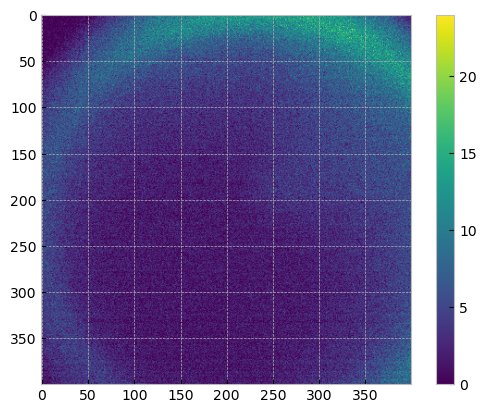

In [5]:
for power in power_measured[:1]:
    plt.imshow(power[600:1000,550:950])
    plt.colorbar()
    plt.show()

To do the curve fitting we can compute the mean or median of the data above along the temporal dimension (zeroth axis), but for simplicity we will just select a value. Below also are the starting points for the `PSG` and `PSA` polarization optics. The red plot at the end of the cell shows what we _think_ our measurement is, whereas the blue dots are what we actually measured.

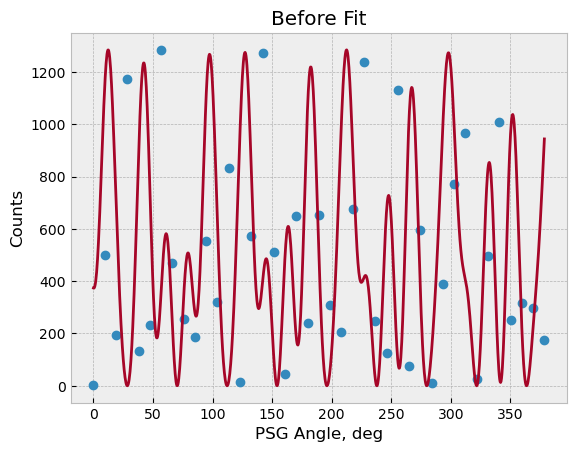

In [8]:
# Select a point in the image
power_sample = power_measured[:,800,800]

# Construct the PSG model
starting_angles={'psg_polarizer':0,
                'psg_qwp':22 * deg2rad,
                'psa_qwp':-10 * deg2rad,
                'psa_polarizer':np.pi/2}
ret = 1.707

# construct the model measurement
psg_angles_longer = np.linspace(psg_angles[0],psg_angles[-1],1000) * deg2rad
psa_angles_longer = np.linspace(psa_angles[0],psa_angles[-1],1000) * deg2rad

psg_qwp = linear_retarder(starting_angles['psg_qwp'] + psg_angles_longer,ret, shape=[1000])
psg_hpl = linear_polarizer(starting_angles['psg_polarizer'], shape=[1000])

psa_qwp = linear_retarder(starting_angles['psa_qwp'] + psa_angles_longer, ret, shape=[1000])
psa_hpl = linear_polarizer(starting_angles['psa_polarizer'], shape=[1000]) 


Mg =  psg_qwp @ psg_hpl
Ma = psa_hpl @ psa_qwp
Msys = Ma @ Mg

power_model = Msys[:,0,0]


plt.figure()
plt.title('Before Fit')
plt.plot(psg_angles, power_sample, linestyle='None', marker='o')
plt.plot(psg_angles_longer * rad2deg, power_model * np.max(power_sample) * 2)
plt.ylabel('Counts')
plt.xlabel('PSG Angle, deg')
plt.show()

**Next** we construct a cost function `minimize_step_error` to fit some free parameters to the curve to our data and back out the current state of the instrument. I wrote it to call `drrp_sinusoid_step` just to make the optimization a little easier to interface with.

In [9]:
def drrp_sinusoid_step(thetas_g, thetas_a, stepg, stepa, ret_g, ret_a, psg_qwp_angle, psa_qwp_angle):
    
    psg_qwp_ret = ret_g
    psa_qwp_ret = ret_a
    
    psg_dia_tmin = 1/250
    psa_dia_tmin = 1/250
    
    psg_pol_angle = 0
    psa_pol_angle = np.pi / 2
    
    thetas_g = thetas_g * stepg
    thetas_a = thetas_a * stepa
    
    starting_angles={'psg_polarizer':psg_pol_angle,
                     'psg_qwp':psg_qwp_angle,
                     'psa_qwp':psa_qwp_angle,
                     'psa_polarizer':psa_pol_angle}

    nmeas = len(thetas_g)

    psg_qwp = linear_retarder(starting_angles['psg_qwp'] + thetas_g, psg_qwp_ret, shape=[nmeas])
    psg_hpl = linear_diattenuator(starting_angles['psg_polarizer'], psg_dia_tmin, shape=[nmeas])

    psa_qwp = linear_retarder(starting_angles['psa_qwp'] + thetas_a, psa_qwp_ret, shape=[nmeas])
    psa_hpl = linear_diattenuator(starting_angles['psa_polarizer'], psa_dia_tmin, shape=[nmeas])
    
    psg = psg_qwp @ psg_hpl
    psa = psa_hpl @ psa_qwp
    M = psa @ psg
    
    g = psg[:,:,0]
    g = g[..., np.newaxis]
    a = psa[:,0,:]
    a = a[..., np.newaxis]
    w = broadcast_kron(g, a)[...,0]
    
    I = np.eye(4).ravel()
    
    power = w @ I
    
    return power

def minimize_step_error(x):
    
    nmeas = len(psg_angles)
    y = x[0] # psg step error
    z = x[1] # psa step error
    ret_g = x[-4]
    ret_a = x[-3]
    psg_angle = x[-2]
    psa_angle = x[-1]
    
    power = drrp_sinusoid_step(psg_angles * deg2rad, psa_angles * deg2rad, y, z, ret_g, ret_a, psg_angle, psa_angle)
    scaled_data = (power_sample / np.max(power_sample) * 0.5)
    diff = power - scaled_data
    cost = np.mean((diff)**2)
    
    return cost

Passing this function to the `BFGS` optimizer will help us find a value that fits well to our starting conditions.

In [10]:
from scipy.optimize import minimize

results = minimize(minimize_step_error,
                   x0=(1, # psg step size
                       1, # psa step size
                       1.707, # qwpg retardance 
                       1.707, # qwpa retardance 
                       0 * deg2rad, # psg offset
                       90 * deg2rad), # psa offset
                   method='BFGS',
                   options={'maxiter':1000, 'xrtol':1e-10})

In [14]:
print(results)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.0001250456359179537
        x: [ 9.943e-01  1.030e+00  1.594e+00  1.586e+00 -5.594e-02
             1.418e+00]
      nit: 29
      jac: [ 3.609e-07 -1.138e-06 -3.092e-07  8.022e-07 -4.538e-07
            -5.323e-08]
 hess_inv: [[ 1.068e+00  9.713e-02 ... -3.369e+00 -1.630e+00]
            [ 9.713e-02  4.529e-02 ... -2.923e-01 -7.876e-01]
            ...
            [-3.369e+00 -2.923e-01 ...  1.463e+01  6.361e+00]
            [-1.630e+00 -7.876e-01 ...  6.361e+00  1.789e+01]]
     nfev: 238
     njev: 34


Below is just a block of code that helps to digest what the new fit parameters are. 

In [12]:
params = ['PSG Angular Step Relative Increment',
          'PSA Angular Step Relative Increment',
          'PSG Retardance, deg',
          'PSA Retardance, deg',
          'PSG Offset Angle, deg',
          'PSG Offset Angle, deg']

for i, (p,u) in enumerate(zip(params,results.x)):
    
    if i < 2:
        print(p,u)
    else:
        print(p,u*rad2deg)

PSG Angular Step Relative Increment 0.9942670065951998
PSA Angular Step Relative Increment 1.0303736528521226
PSG Retardance, deg 91.31137346124565
PSA Retardance, deg 90.89918860657002
PSG Offset Angle, deg -3.2053896536666895
PSG Offset Angle, deg 81.2239439686766


If we drop these revised parameters into our function that evaluates the power observed after the `DRRMP` we see that we got a pretty good fit.

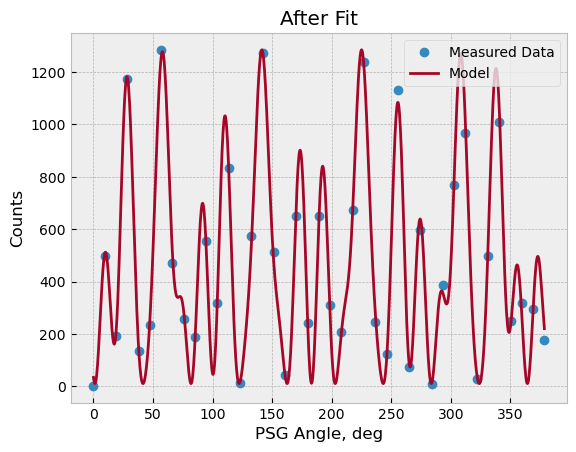

In [16]:
power_model_fit = drrp_sinusoid_step(psg_angles_longer, psa_angles_longer, *results.x)
plt.style.use('bmh')

plt.figure()
plt.title('After Fit')
plt.plot(psg_angles, power_sample, linestyle='None', marker='o', label='Measured Data')
plt.plot(psg_angles_longer * rad2deg, power_model_fit * np.max(power_sample) * 2, label='Model')
plt.ylabel('Counts')
plt.xlabel('PSG Angle, deg')
plt.legend()
plt.show()

**The next step** is to plug these fit values back into our Mueller Matrix measurement to construct a more accurate polarimeteric data reduction matrix. This starts by revising the angles traveled by the `PSG` and `PSA`

In [17]:
revised_psg_angles = psg_angles * results.x[0]
revised_psa_angles = psa_angles * results.x[1]

## Performing a Measurement
This is the exact same procedure as taking calibration data. The only stipulation here is that there must be _at least_ 16 images for a physically complete Mueller Matrix measurement. However, for sufficiently low error $40$ measurements is a decent optimum between time and accuracy. 

Below we show an illustrative example of the measurement of a polarizer and show the resultant Mueller Matrix image.

In [20]:
# Load the new measurement
power_measurement = np.load('20240419_Mueller_Polarizer_Measurement_01.npy')
power_selected = power_measurement[:,600:1000, 550:950]
power_selected = np.moveaxis(power_selected,0,-1)
offset_g = revised_psg_angles[-1] - (1 * 360)
offset_a = revised_psa_angles[-1] - (5 * 360)
print('PSG Offset = ',offset_g)
print('PSG Offset = ',offset_a)

PSG Offset =  16.36895018651694
PSG Offset =  265.5439892040413


In [21]:
# Hard-coded Mueller Polarimetry
psg_qwp_ret = results.x[2]
psa_qwp_ret = results.x[3]

psg_dia_tmin = 1/250
psa_dia_tmin = 1/250

psg_pol_angle = 0
psa_pol_angle = np.pi / 2
psg_qwp_angle = results.x[4] + offset_g * deg2rad
psa_qwp_angle = results.x[5] + offset_a * deg2rad
    

starting_angles={'psg_polarizer':psg_pol_angle,
                     'psg_qwp':psg_qwp_angle,
                     'psa_qwp':psa_qwp_angle,
                     'psa_polarizer':psa_pol_angle}

psg_qwp = linear_retarder(starting_angles['psg_qwp']+revised_psg_angles * deg2rad, psg_qwp_ret, shape=[400, 400, nmeas])
psg_hpl = linear_diattenuator(starting_angles['psg_polarizer'], Tmin=psg_dia_tmin, shape=[nmeas])

psa_qwp = linear_retarder(starting_angles['psa_qwp']+revised_psa_angles * deg2rad, psa_qwp_ret, shape=[400, 400, nmeas])
psa_hpl = linear_diattenuator(starting_angles['psa_polarizer'], Tmin=psa_dia_tmin, shape=[nmeas])

Mg =  psg_qwp @ psg_hpl
Ma = psa_hpl @ psa_qwp

PSA = Ma[...,0,:]
PSG = Mg[...,:,0]

# polarimetric data reduction matrix, flatten Mueller matrix dimension
Wmat = broadcast_kron(PSA[...,np.newaxis], PSG[...,np.newaxis])
Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
Winv = np.linalg.pinv(Wmat)
power_expand = power_selected[..., np.newaxis] / np.max(power_selected) * 0.5
print(power_expand.shape)
print(Winv.shape)

# Do the data reduction
M_meas = Winv @ power_expand
M_meas = M_meas[...,0]
M_shaped = M_meas.reshape([400,400,4,4])

(400, 400, 41, 1)
(400, 400, 16, 41)


In [22]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def mm_image(M, normalized=True, vmin=None, vmax=None):
    
    
    fig, ax = plt.subplots(ncols=4, nrows=4, figsize=[9,7.5])
    
    for i in range(4):
        for j in range(4):
            ax[i,j].set_title(f'M{i}{j}')
            
            if normalized:
                if (i == 0) and (j == 0):
                    im = ax[i,j].imshow((M[...,i,j]), vmin=vmin, vmax=vmax, cmap='gray')
                else:
                    im = ax[i,j].imshow(M[...,i,j] / M[...,0,0], vmin=-1, vmax=1, cmap='bwr')
            else:
                im = ax[i,j].imshow(M[...,i,j], vmin=vmin, vmax=vmax, cmap='coolwarm')
            div = make_axes_locatable(ax[i,j])
            cax = div.append_axes("right", size="7%", pad="2%")
            cb1 = fig.colorbar(im, cax=cax)
            ax[i,j].set_xticks([])
            ax[i,j].set_xticklabels([])
            ax[i,j].set_yticks([])
            ax[i,j].set_yticklabels([])
            
    plt.show()

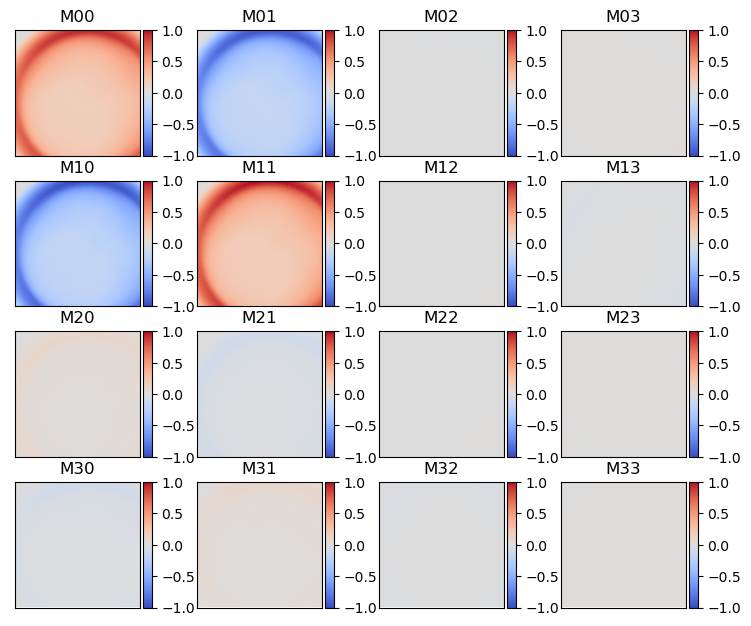

In [23]:
plt.style.use('default')
mm_image(M_shaped, normalized=False, vmax=1, vmin=-1)

This is about what we would expect from a vertically-oriented polarizer so we know we our measurement is pretty good!